An in development Python package to manipulate netcdf files.

Goals



# What it is not

Fundamentally, this package does not provide a full interface to all of the options available within CDO and NCO. Instead, this package aims to provide functionality that will cover 80-90% of the use cases when manipulating netcdf files. This will naturally involve some judgement and will be influenced by current work needs.


# System requirements
This will require both CDO and NCO to be installed on your computer. At present the package will not work on Windows because I have not had time to rewrite the system calls.

## Introducing trackers

The fundamental object of analysis in this package is a tracker. This object will store the start point of any manipulations. This will either be a single file or an ensemble of files. It will also store the current position of the manipulations. This is a single netcdf file stored in a temporary folder. In a similar vein, the package will track the history of manipulations on the terminal or within Python.


# Basic usage

# Initializing a tracker
I will illustrate the basic usage using a climatology of global sea surface temperature from NOAA.
We can download this using wget as follow.


wget ftp://ftp.cdc.noaa.gov/Datasets/COBE2/sst.mon.ltm.1981-2010.nc

The first step in any analysis will be to import nchack, which I will call nch as shorthand.

In [20]:
import nchack as nch

We can then set up the tracker file which we will use for manipulating the SSt climatology.

In [21]:
ff =  "sst.mon.ltm.1981-2010.nc"
tracker = nch.NCTracker(ff)

At this point there is very little useful information in the tracker. Essentially, all it tell us is the start file.

In [22]:
tracker.start

'sst.mon.ltm.1981-2010.nc'

We tracker history as follows, which is initially empty.

In [23]:
tracker.history

[]

Similarly, we track the current file using current. This is the same as the start file initially.

In [35]:
tracker.current

'/tmp/tmph8owo1d_.nc'

# File variables

A simple, but important first task when analyzing netcdf data is knowing the variables in the file. We can do this quickly using the variables method.

In [37]:
nch.variables(tracker)

['sst', 'valid_yr_count']

## Clipping operations
We can clip netcdf files in space or time using clip. Let's say we only cared about temperature in July for the North Atlantic. This be found very easily using the following.

In [29]:
tracker = nch.NCTracker(ff)
tracker.clip(months = 1)
tracker.clip(lat_range = [30, 80], lon_range = [-80, 20])

/tmp/tmp_82_3hcv.nc
/tmp/tmp2v26yvw8.nc


/tmp/tmph8owo1d_.nc


We have now carried out some manipulations on the tracker. So, the current file has now changed.

In [31]:
tracker.current

'/tmp/tmph8owo1d_.nc'

Likewise, we now have a history to look at.

In [33]:
tracker.history

['cdo selmonth,1 /users/modellers/rwi/nchack/sst.mon.ltm.1981-2010.nc /tmp/tmpfqccrnxf.nc',
 'cdo sellonlatbox,-80,20,30,80 /tmp/tmp_82_3hcv.nc /tmp/tmp8qvg0txq.nc']

## Importing to xarray

xarray is a powerful netcdf manipulation tool. In fact, in some use cases it will be more computationally efficient than CDO or NCO. nchack has a built in method for reading the tracker's current state in as an xarrary format, to_xarray.

/tmp/tmph8owo1d_.nc


/users/modellers/rwi/anaconda3/lib/python3.7/site-packages/xarray/coding/times.py:419: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  self.use_cftime)
/users/modellers/rwi/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:538: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


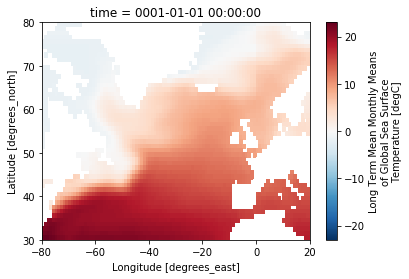

In [53]:
tracker.to_xarray().sst.plot()

# Method chaining

# Cleaning up temporary files

Both CDO and NCO create new files each time they do any manipulations. This approach has the computational advantage of reducing RAM usage. However, it risks clogging up your temporary folder and killing your computer. This risk is averted by carrying automatic clean up.

Consider the following chain:


 
 


In [26]:
(
 NCTracker(ff)
 .clip(months = 1)
 .surface()
 .remap(coords = coords)
 .to_xarray()
 )

NameError: name 'NCTracker' is not defined

At each part of the chain temporary files are created. However, we are clearly only interested in the final file generated as part of the chain. nchack therefore automatically cleans up any files we are not interested in.

Methods applied to a tracker will automatically clean up the temporary files generated under the assumption that the start file and the current file are the only files we need.

More broadly, nchack contains a cleanup function. Behind the scenes nchack will track all temporary folders ever generated in the current interactive session. These files can be seen by calling nch.nc_created. The clean up function is then able to look through all of the files that have been generated by nchack in the current session and remove any that are not required by an existing tracker. This will prevent the temporary folder being clogged up by files.

## Deleting an object

The code "del object" will delete an object and also delete object.current from the system. However, this will only happen on garbage collection and once there are no references to object in the present session.

# Copying a tracker

It is likely that a user will want to be able to manipulate the current state of a tracker in a variety of different ways. For example, you might want to calculate different summary statistics. Simply manipulating the existing tracker will not work in this case because the netcdf file with the current state will be deleted. nchack therefore offers a restart option. This will generate a new tracker where the starting point is the current state of the tracker being copied.
Of course, this can also be achieved using nch.NCTracker(tracker.current).

In [ ]:
new_tracker = tracker.restart()